## 생성적 적대 신경망(GAN)
- 딥러닝의 원리를 활용해 가상 이미지를 생성하는 알고리즘
- 진짜 같은 가짜를 만들기 위해 GAN 알고리즘 내부에서 '적대적' 경합을 진행함
- 한쪽은 가짜를 만들고, 한쪽은 진짜와 비교하는 경합과정을 이용하는 것이 GAN의 원리
- 생성자(Generator) : 가짜를 만들어내는 파트
- 판별자(Discriminator) : 진위를 가려내는 파트
- DCGAN : 컨볼루션 신경망 + GAN 알고리즘, 불안정하던 초기의 GAN을 크게 보완해줌

### 생성자(Generator)
- 가상의 이미지를 만들어내는 공장
- 처음에는 랜덤한 픽셀 값으로 채워진 가짜 이미지-> 판별자의 판별 결과에 따른 지속적인 업데이트 -> 점차 원하는 이미지를 만듬
- 판별과 학습이 생성자에서 일어나는 것이 아니 때문에 옵티마이저를 사용하는 최적화 과정이나 컴파일하는 과정이 없음(DCGAN에서 사용되는 컨볼루션 신경망의 특징)
- 일부 매개변수를 삭제하는 풀링(pooling)이 없는 대신 패딩(padding)(입력 크기와 출력 크기를 똑같이 맞추기 위해서)
<br>
- 생성자의 활성화 함수로 ReLU(),판별자로 넘겨주기 직전에 tanh()
- tanh()를 쓰면 출력되는 값을 -1~1 사이로 맞출 수 있음
- 판별자에 입력될 픽셀 범위도 -1~1로 맞추면 판별 조건이 모두 갖추어짐

#### padding
- 패딩 과정을 통해 생성자가 만들어 내는 이미지의 크기를 조절해야 하는 이유는 판별자가 비교할 '진짜'와 똑같은 크기가 되어야 하기 때문
- padding='same'이라는 설정을 통해 입력과 출력의 크기가 다른 경우 자동으로 크기를 확장해주고, 확장된 공간에 0을 채워넣음
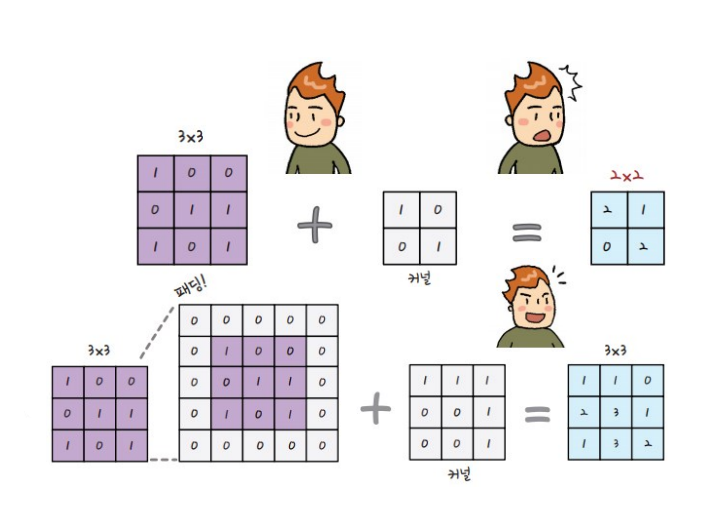

#### 배치 정규화
- 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치
- 다음 층으로 입력될 값을 일정하게 재배치하는 역할을 함
- 이 과정을 통해 층의 개수가 늘어나도 안정적인 학습을 진행할 수 있음

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

### 판별자(Discriminator)
- 생성자에서 넘어온 이미지가 가짜인지 진짜인지를 판별해주는 장치
- 컨볼루션 신경망의 구조를 그대로 가지고 와서 만들면 됨
- 컨볼루션 신경망이란 원래 무언가를 구별하는데 최적화된 알고리즘이기 때문에 그 목적 그대로 사용하면 됨
- 진짜(1) 가짜(0)를 결정하는 문제이므로 컴파일 부분은 이진 로스 함수(binary_crossentropy)와 최적화함수(adam)
- 드롭아웃(Dropout) + 배치 정규화 + 패딩
- 주의 할 점은 가짜인지 진짜인지를 판별만 해 줄 뿐, 자기 자신이 학습을 해서는 안됨
- 판별자가 얻은 가중치는 판별자 자시닝 학습하는데 쓰이는 것이 아니라 생성자로 넘겨주어 생성자가 업데이트된 이미지를 만들도록 해야함
- 판별자를 만들 때는 가중치를 저장하는 학습 기능을 꺼야 함

In [3]:
# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

### 적대적 신경망 실행하기
- 생성자와 판별자를 연결시키고 학습을 진행하며 기타 여러 옵션을 설정하는 순서
- 연결시킨다는 것은 생성자에서 나온 출력을 판별자에 넣어서 진위 여부를 판별하게 만든다는 의미

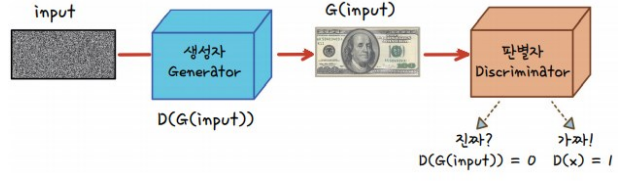
생성자 G()에 입력값 input을 넣은 결과 G(input)<br>
판별자 D()에 넣은 결과 D(G(input))<br>
생성자는 D(G(input))이 참(1)이라고 주장하지만, 판별자는 실제 데이터인 x로 만든 D(x)만 참이라고 여김<br>
그러다 학습이 진행될수록 생성자가 만들 G(input)이 실제와 너무나 가까워져서 이것으로 만든 D(G(input))과 실제 데이터로 만든 D(x)를 잘 구별하지 못하게 됨<br>
너무나 유사해진 D(G(input))과 D(x)를 판별자가 더는 구별하지 못하게 되어 정확도가 0.5에 가까워질때, 비로소 생성자는 자신의 역할을 다하게 되어 학습 종료<br>

In [4]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


1/1 [==============================] - 0s 47ms/step
epoch:0  d_loss:0.4740  g_loss:0.2672
1/1 [==============================] - 0s 56ms/step
epoch:1  d_loss:0.3963  g_loss:0.0389
1/1 [==============================] - 0s 56ms/step
epoch:2  d_loss:0.4567  g_loss:0.0054
1/1 [==============================] - 0s 54ms/step
epoch:3  d_loss:0.5411  g_loss:0.0031
1/1 [==============================] - 0s 58ms/step
epoch:4  d_loss:0.5753  g_loss:0.0115
1/1 [==============================] - 0s 56ms/step
epoch:5  d_loss:0.5152  g_loss:0.0924
1/1 [==============================] - 0s 47ms/step
epoch:6  d_loss:0.4717  g_loss:0.3482
1/1 [==============================] - 0s 64ms/step
epoch:7  d_loss:0.5442  g_loss:0.4098
1/1 [==============================] - 0s 47ms/step
epoch:8  d_loss:0.5283  g_loss:0.3881
1/1 [==============================] - 0s 46ms/step
epoch:9  d_loss:0.4991  g_loss:0.3860
1/1 [==============================] - 0s 56ms/step
epoch:10  d_loss:0.4296  g_loss:0.4831
1/1 [====

epoch:89  d_loss:0.3230  g_loss:1.4370
1/1 [==============================] - 0s 47ms/step
epoch:90  d_loss:0.3631  g_loss:1.2420
1/1 [==============================] - 0s 59ms/step
epoch:91  d_loss:0.3084  g_loss:1.4366
1/1 [==============================] - 0s 47ms/step
epoch:92  d_loss:0.3066  g_loss:1.3936
1/1 [==============================] - 0s 47ms/step
epoch:93  d_loss:0.2688  g_loss:1.3392
1/1 [==============================] - 0s 47ms/step
epoch:94  d_loss:0.2523  g_loss:1.2596
1/1 [==============================] - 0s 45ms/step
epoch:95  d_loss:0.3628  g_loss:1.2094
1/1 [==============================] - 0s 47ms/step
epoch:96  d_loss:0.2591  g_loss:1.1514
1/1 [==============================] - 0s 47ms/step
epoch:97  d_loss:0.2187  g_loss:1.0827
1/1 [==============================] - 0s 47ms/step
epoch:98  d_loss:0.2770  g_loss:1.1264
1/1 [==============================] - 0s 62ms/step
epoch:99  d_loss:0.3888  g_loss:0.9364
1/1 [==============================] - 0s 43ms/step

1/1 [==============================] - 0s 47ms/step
epoch:179  d_loss:0.5140  g_loss:1.3539
1/1 [==============================] - 0s 53ms/step
epoch:180  d_loss:0.5314  g_loss:1.2900
1/1 [==============================] - 0s 47ms/step
epoch:181  d_loss:0.5956  g_loss:1.3816
1/1 [==============================] - 0s 47ms/step
epoch:182  d_loss:0.4753  g_loss:1.5890
1/1 [==============================] - 0s 62ms/step
epoch:183  d_loss:0.6730  g_loss:1.4334
1/1 [==============================] - 0s 47ms/step
epoch:184  d_loss:0.6655  g_loss:1.4353
1/1 [==============================] - 0s 47ms/step
epoch:185  d_loss:0.4623  g_loss:1.5271
1/1 [==============================] - 0s 62ms/step
epoch:186  d_loss:0.5287  g_loss:1.5962
1/1 [==============================] - 0s 47ms/step
epoch:187  d_loss:0.5681  g_loss:1.5071
1/1 [==============================] - 0s 47ms/step
epoch:188  d_loss:0.5108  g_loss:1.4576
1/1 [==============================] - 0s 43ms/step
epoch:189  d_loss:0.4078  g_

1/1 [==============================] - 0s 47ms/step
epoch:267  d_loss:0.4834  g_loss:1.9448
1/1 [==============================] - 0s 51ms/step
epoch:268  d_loss:0.8025  g_loss:1.8125
1/1 [==============================] - 0s 47ms/step
epoch:269  d_loss:0.4836  g_loss:1.9838
1/1 [==============================] - 0s 47ms/step
epoch:270  d_loss:0.5846  g_loss:1.7282
1/1 [==============================] - 0s 45ms/step
epoch:271  d_loss:0.5646  g_loss:1.7927
1/1 [==============================] - 0s 47ms/step
epoch:272  d_loss:0.5828  g_loss:2.0816
1/1 [==============================] - 0s 49ms/step
epoch:273  d_loss:0.5361  g_loss:2.2627
1/1 [==============================] - 0s 69ms/step
epoch:274  d_loss:0.7220  g_loss:1.8720
1/1 [==============================] - 0s 53ms/step
epoch:275  d_loss:0.7015  g_loss:1.4185
1/1 [==============================] - 0s 59ms/step
epoch:276  d_loss:0.7395  g_loss:1.6139
1/1 [==============================] - 0s 59ms/step
epoch:277  d_loss:0.5812  g_

1/1 [==============================] - 0s 47ms/step
epoch:356  d_loss:0.4810  g_loss:2.1502
1/1 [==============================] - 0s 47ms/step
epoch:357  d_loss:0.4230  g_loss:2.0984
1/1 [==============================] - 0s 63ms/step
epoch:358  d_loss:0.4092  g_loss:1.4534
1/1 [==============================] - 0s 62ms/step
epoch:359  d_loss:0.4972  g_loss:1.6226
1/1 [==============================] - 0s 62ms/step
epoch:360  d_loss:0.3666  g_loss:1.6675
1/1 [==============================] - 0s 62ms/step
epoch:361  d_loss:0.4635  g_loss:2.0048
1/1 [==============================] - 0s 62ms/step
epoch:362  d_loss:0.4569  g_loss:1.9942
1/1 [==============================] - 0s 47ms/step
epoch:363  d_loss:0.5605  g_loss:2.0333
1/1 [==============================] - 0s 47ms/step
epoch:364  d_loss:0.5009  g_loss:1.7589
1/1 [==============================] - 0s 47ms/step
epoch:365  d_loss:0.4804  g_loss:1.9834
1/1 [==============================] - 0s 53ms/step
epoch:366  d_loss:0.4890  g_

1/1 [==============================] - 0s 47ms/step
epoch:444  d_loss:0.4162  g_loss:2.0703
1/1 [==============================] - 0s 62ms/step
epoch:445  d_loss:0.2584  g_loss:3.0234
1/1 [==============================] - 0s 62ms/step
epoch:446  d_loss:0.3312  g_loss:3.9560
1/1 [==============================] - 0s 62ms/step
epoch:447  d_loss:0.3437  g_loss:3.4664
1/1 [==============================] - 0s 47ms/step
epoch:448  d_loss:0.5670  g_loss:2.7844
1/1 [==============================] - 0s 47ms/step
epoch:449  d_loss:0.6606  g_loss:1.4352
1/1 [==============================] - 0s 47ms/step
epoch:450  d_loss:0.4054  g_loss:1.3105
1/1 [==============================] - 0s 47ms/step
epoch:451  d_loss:0.4412  g_loss:1.8587
1/1 [==============================] - 0s 39ms/step
epoch:452  d_loss:0.3249  g_loss:2.3449
1/1 [==============================] - 0s 47ms/step
epoch:453  d_loss:0.3949  g_loss:2.8111
1/1 [==============================] - 0s 55ms/step
epoch:454  d_loss:0.4358  g_

1/1 [==============================] - 0s 46ms/step
epoch:533  d_loss:0.2123  g_loss:2.7837
1/1 [==============================] - 0s 58ms/step
epoch:534  d_loss:0.2288  g_loss:3.3394
1/1 [==============================] - 0s 62ms/step
epoch:535  d_loss:0.1883  g_loss:2.6234
1/1 [==============================] - 0s 47ms/step
epoch:536  d_loss:0.3457  g_loss:2.4922
1/1 [==============================] - 0s 47ms/step
epoch:537  d_loss:0.3638  g_loss:2.3294
1/1 [==============================] - 0s 46ms/step
epoch:538  d_loss:0.3688  g_loss:3.1810
1/1 [==============================] - 0s 47ms/step
epoch:539  d_loss:0.4839  g_loss:2.3872
1/1 [==============================] - 0s 63ms/step
epoch:540  d_loss:0.3091  g_loss:2.8987
1/1 [==============================] - 0s 62ms/step
epoch:541  d_loss:0.1933  g_loss:3.7916
1/1 [==============================] - 0s 47ms/step
epoch:542  d_loss:0.3992  g_loss:2.6601
1/1 [==============================] - 0s 62ms/step
epoch:543  d_loss:0.7701  g_

1/1 [==============================] - 0s 62ms/step
epoch:621  d_loss:0.1340  g_loss:2.5784
1/1 [==============================] - 0s 47ms/step
epoch:622  d_loss:0.1707  g_loss:2.7451
1/1 [==============================] - 0s 52ms/step
epoch:623  d_loss:0.2538  g_loss:2.5405
1/1 [==============================] - 0s 47ms/step
epoch:624  d_loss:0.1414  g_loss:2.6642
1/1 [==============================] - 0s 62ms/step
epoch:625  d_loss:0.1327  g_loss:2.8920
1/1 [==============================] - 0s 62ms/step
epoch:626  d_loss:0.0802  g_loss:3.4800
1/1 [==============================] - 0s 38ms/step
epoch:627  d_loss:0.1748  g_loss:2.9447
1/1 [==============================] - 0s 47ms/step
epoch:628  d_loss:0.2129  g_loss:3.0338
1/1 [==============================] - 0s 62ms/step
epoch:629  d_loss:0.1884  g_loss:3.1205
1/1 [==============================] - 0s 62ms/step
epoch:630  d_loss:0.1927  g_loss:3.5458
1/1 [==============================] - 0s 47ms/step
epoch:631  d_loss:0.1183  g_

KeyboardInterrupt: 

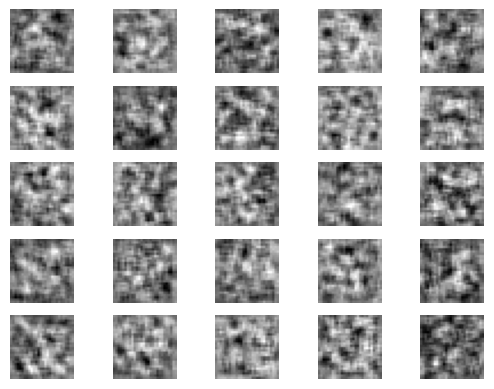

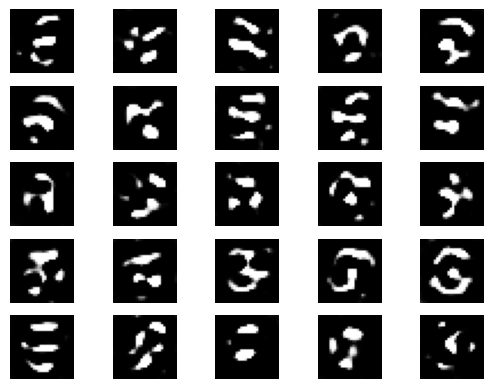

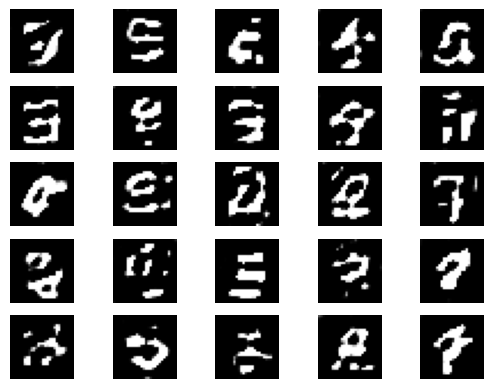

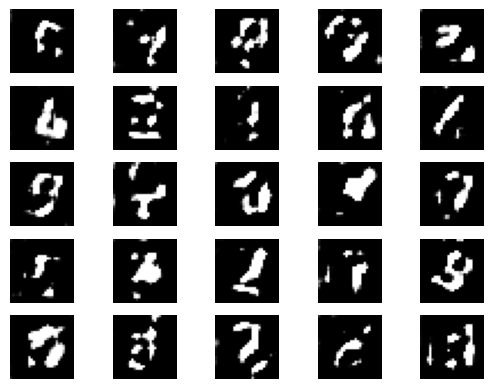

In [6]:
# 지금까지의 모든 과정을 실행할 함수 만들기

def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 
    #단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  
    # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 
    # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다.
        # 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("../../../../data/python_data/gan_images/gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.

## 오토인코더(Auto-Encoder,AE)
- 딥러닝을 이용해 가상의 이미지를 만드는 또 다른알고리즘
- GAN과 비슷한 결과를 만들지만, 다른 성질을 지니고 있음
- GAN이 세사엥 존재하지 않는 가상의 것을 만들어 내는 반면에, 오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어냄

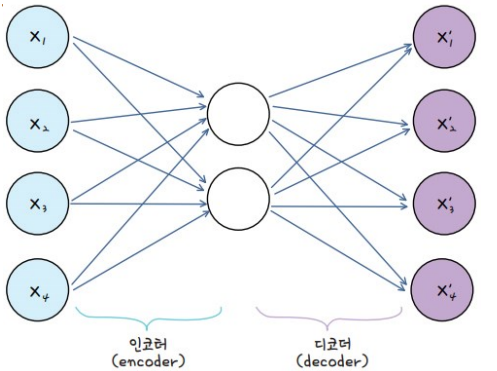
- 입력한 이미지와 똑같은 크기로 출력층을 만듬
- 입력층보다 적은 수의 노드를 가진 은닉층을 중간에 넣어서 차원을 줄여줌
- 이때 소실된 데이터를 복원하기 위해 학습을 시작하고, 이 과정을 통해 입력 데이터의 특징을 효율적으로 응축한 새로운 출력이 나오는 원리

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분이 이어집니다. 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인해 봅니다.
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 8)          

Epoch 1/50
469/469 [==============================] - 62s 129ms/step - loss: 0.2066 - val_loss: 0.1411
Epoch 2/50
469/469 [==============================] - 57s 122ms/step - loss: 0.1293 - val_loss: 0.1192
Epoch 3/50
469/469 [==============================] - 54s 114ms/step - loss: 0.1159 - val_loss: 0.1109
Epoch 4/50
469/469 [==============================] - 54s 114ms/step - loss: 0.1092 - val_loss: 0.1053
Epoch 5/50
469/469 [==============================] - 52s 111ms/step - loss: 0.1046 - val_loss: 0.1017
Epoch 6/50
469/469 [==============================] - 55s 118ms/step - loss: 0.1012 - val_loss: 0.0988
Epoch 7/50
469/469 [==============================] - 52s 111ms/step - loss: 0.0986 - val_loss: 0.0962
Epoch 8/50
469/469 [==============================] - 55s 118ms/step - loss: 0.0968 - val_loss: 0.0947
Epoch 9/50
469/469 [==============================] - 53s 114ms/step - loss: 0.0954 - val_loss: 0.0939
Epoch 10/50
469/469 [==============================] - 53s 113ms/step - l

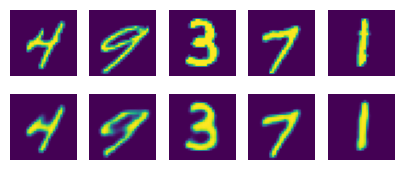

In [8]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):       # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28)) # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()
# 첫 번째 줄이 원본
# 두 번째 줄이 원본의 특징을 담은 오토인코더 이미지